<a href="https://colab.research.google.com/github/heko0826/HobbyColabProjects/blob/main/Imageset_RPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 次のRPCAの原著論文にあるが, Yale B Databaseにおいて, Lが顔の主成分, Sが影、鏡面反射、彩度を表しているようになるらしい. 
- これでは, 逆に低ランク近似で主成分を抽出しているだけのように思える. 
https://arxiv.org/pdf/0912.3599.pdf

In [1]:
!wget -nc http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip
!unzip -u CroppedYale.zip

Cloning into 'segmentation_WBC'...
remote: Enumerating objects: 898, done.
remote: Total 898 (delta 0), reused 0 (delta 0), pack-reused 898
Receiving objects: 100% (898/898), 26.08 MiB | 10.23 MiB/s, done.
Resolving deltas: 100% (112/112), done.
--2021-12-12 09:15:56--  http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58493820 (56M) [application/zip]
Saving to: ‘CroppedYale.zip’

CroppedYale.zip     100%[===================>]  55.78M   311KB/s    in 3m 4s   

2021-12-12 09:19:01 (310 KB/s) - ‘CroppedYale.zip’ saved [58493820/58493820]

Archive:  CroppedYale.zip
   creating: CroppedYale/yaleB39/
  inflating: CroppedYale/yaleB39/WS_FTP.LOG  
  inflating: CroppedYale/yaleB39/yaleB39_P00.info  
  inflating: CroppedYale/yaleB39/yaleB39_P00A+000E+00.pgm  
  inflating: CroppedYale/yale

In [2]:
!ls

CroppedYale  CroppedYale.zip  sample_data  segmentation_WBC


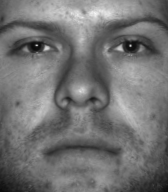

In [13]:
from PIL import Image

datafolder_path = "./CroppedYale/yaleB01/"
Image.open(datafolder_path + "yaleB01_P00A+000E+00.pgm")

In [14]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Yale Cropped
imgs = []
for f in glob.glob("./CroppedYale/yaleB01/*pgm"):
  img = Image.open(f).convert("L")
  img = img.resize((120, 120))
  img = np.array(img)
  img = (img - img.min()) / (img.max() - img.min())
  imgs.append(img)

In [15]:
np.array(imgs).shape

(65, 120, 120)

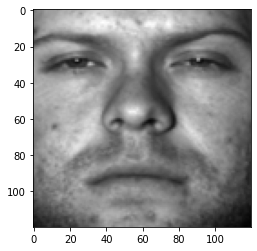

In [16]:
plt.imshow(imgs[0], cmap="gray", vmin=0, vmax=1)
plt.show()

(65, 14400)


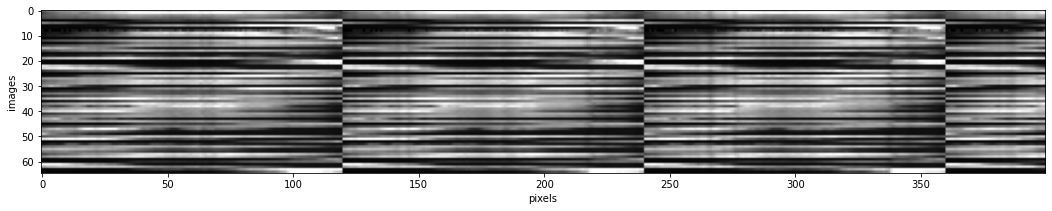

In [17]:
D = np.reshape(imgs, (len(imgs), -1))
print(D.shape)
plt.figure(figsize=(18, 6))
plt.imshow(D.T[:400].T, cmap="gray")
plt.xlabel("pixels")
plt.ylabel("images")
plt.show()

In [18]:
import torch

DD = torch.from_numpy(D).float()
# DD = torch.from_numpy(D.T[:200].T).float()

u, s, vh = torch.linalg.svd(DD, full_matrices=False)
print(u.shape)
print(s.shape)
print(vh.shape)

torch.Size([65, 65])
torch.Size([65])
torch.Size([65, 14400])


Nuclear norm of a
sum of s:  1009.947998046875
nuc norm a:  1009.9478759765625


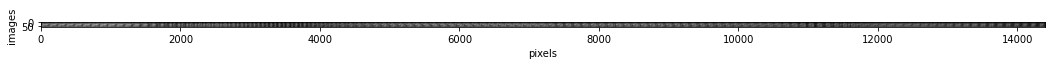

In [19]:
print("Nuclear norm of a")
print("sum of s: ", torch.linalg.norm(s, ord=1).item())
print("nuc norm a: ", torch.linalg.norm(DD, ord="nuc").item())
DD_re = torch.matmul(torch.matmul(u, s.diag()), vh)

plt.figure(figsize=(18, 6))
plt.imshow(DD_re, cmap="gray")
plt.ylabel("images")
plt.xlabel("pixels")
plt.show()

[ 10/100]: loss = 702.7504,  
[ 20/100]: loss = 633.4976,  
[ 30/100]: loss = 593.6198,  
[ 40/100]: loss = 563.6258,  
[ 50/100]: loss = 541.0001,  
[ 60/100]: loss = 521.0102,  
[ 70/100]: loss = 502.0803,  
[ 80/100]: loss = 484.0207,  
[ 90/100]: loss = 468.4962,  
[100/100]: loss = 456.6985,  
2779.0687084198  [ms]


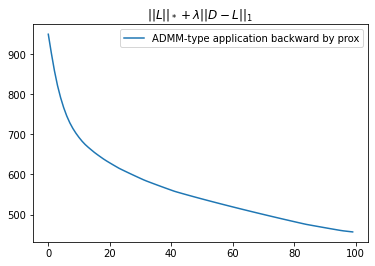

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)

## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


### Algorithm
from time import time

D = DD.clone().float().to(device)

m, n = imgs[0].shape

# Hyperparameters
# ls = 1./np.sqrt(max(m,n)) / 32
ls = 1e-3
ln = 1.
le = 1e+6

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ls))
l2loss = lambda x: torch.sum(x**2)

L, S, E, Y = 0, 0, 0, 0

t = time()
num_iter = 100
display_step = num_iter // 10
history_loss_inexact = []

for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)
    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')

plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()
plt.show()

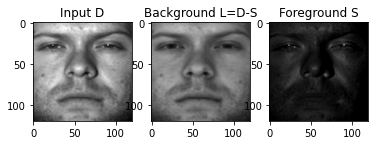

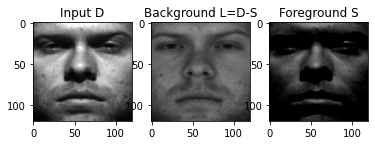

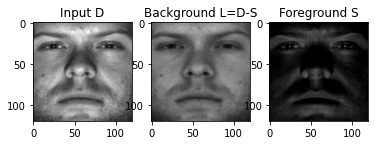

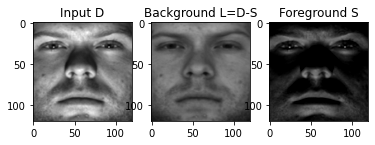

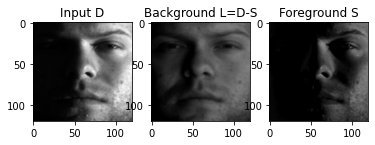

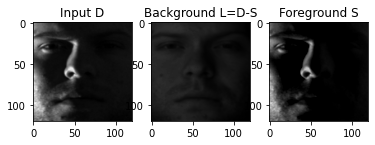

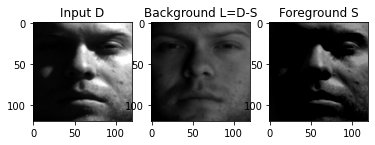

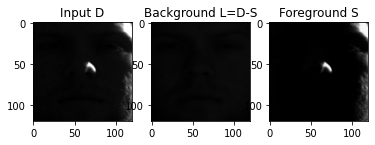

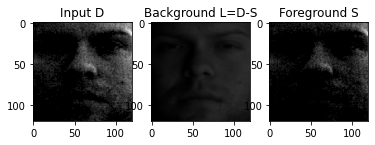

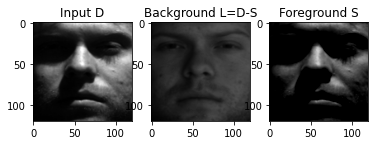

In [21]:
l = torch.reshape(L, (-1, imgs[0].shape[0], imgs[0].shape[1]))
s = torch.reshape(S, (-1, imgs[0].shape[0], imgs[0].shape[1]))
d = torch.reshape(D, (-1, imgs[0].shape[0], imgs[0].shape[1]))


for i in range(10):
  fig, ax = plt.subplots(1, 3)
  ax[0].set_title("Input D")
  ax[0].imshow(d.cpu().data.numpy()[i], cmap="gray", vmin=0, vmax=1)
  ax[1].set_title("Background L=D-S")
  ax[1].imshow(l.cpu().data.numpy()[i], cmap="gray", vmin=0, vmax=1)
  ax[2].set_title("Foreground S")
  im = ax[2].imshow(s.cpu().data.numpy()[i], cmap="gray", vmin=0, vmax=1)
  # fig.colorbar(im)
  plt.show()